# Auto-Graph-RAG Nations Dataset Demo

This notebook demonstrates Auto-Graph-RAG using the **Nations dataset** from PyKEEN, a real-world knowledge graph of international relations between 14 countries.

## Dataset Overview
- **14 countries**: USA, USSR, China, UK, Brazil, India, Egypt, Israel, Jordan, Indonesia, Cuba, Poland, Burma, Netherlands
- **55 relationship types**: embassy, militaryalliance, economicaid, treaties, tourism, trade, etc.
- **1,592 relationship instances**: Real diplomatic, economic, and political relationships

## What we'll build
A question-answering system that can answer queries like:
- "Which countries have embassies with the USA?"
- "What military alliances exist in the dataset?"
- "Which countries have economic aid relationships?"
- "What are the tourism relationships between countries?"

## Setup and Environment Detection

In [37]:
!rm auto-graph-rag -R

#Install Dependancies if Running it Colab

In [ ]:
# Uncomment and run if in Colab
# if in_colab:
# Install PyKEEN and Auto-Graph-RAG
!pip install pykeen

# Clone and install auto-graph-rag if not already done

!git clone https://github.com/benjaminwfriedman/auto-graph-rag.git /content/auto-graph-rag
!cd /content/auto-graph-rag && pip install -e .

In [2]:
import sys
import os
from pathlib import Path

# Detect environment and set working directory
try:
    import google.colab
    in_colab = True
    work_dir = Path("/content/auto-graph-rag/nations_demo_workspace")
    sys.path.append("/content/auto-graph-rag/src")
    print("🔍 Detected Google Colab environment")
except ImportError:
    in_colab = False
    work_dir = Path("./nations_demo_workspace")
    local_src = Path("./src")
    if local_src.exists():
        sys.path.append(str(local_src))
    print("🔍 Detected local environment")

# Create working directory
work_dir.mkdir(exist_ok=True)
print(f"📁 Working directory: {work_dir.absolute()}")

🔍 Detected Google Colab environment
📁 Working directory: /content/auto-graph-rag/nations_demo_workspace


## Environment Variables Setup

In [ ]:
# Set your API keys here
os.environ["OPENAI_API_KEY"] = ""  # Required
os.environ["HF_TOKEN"] = ""      # Optional but recommended

# Check environment
has_openai = bool(os.getenv("OPENAI_API_KEY")) and os.getenv("OPENAI_API_KEY") != "your-openai-api-key-here"
has_hf = bool(os.getenv("HF_TOKEN")) and os.getenv("HF_TOKEN") != "your-huggingface-token-here"

print(f"🔑 OpenAI API Key: {'✅ Available' if has_openai else '❌ Missing - Required for this demo'}")
print(f"🤗 HuggingFace Token: {'✅ Available' if has_hf else '⚠️ Missing - Recommended for model downloads'}")

if not has_openai:
    print("\n❌ Please set your OpenAI API key above to continue with the demo.")
    print("   You can get one at: https://platform.openai.com/api-keys")

🔑 OpenAI API Key: ✅ Available
🤗 HuggingFace Token: ✅ Available


## Import Libraries

In [4]:
import pykeen.datasets
import networkx as nx
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Import Auto-Graph-RAG modules
from auto_graph_rag.modules import (
    GraphBuilder,
    GraphExplorer,
    DataGenerator,
    ModelTrainer,
    QueryExecutor
)

print("✅ All imports successful!")
print("Available modules:")
for module in [GraphBuilder, GraphExplorer, DataGenerator, ModelTrainer, QueryExecutor]:
    print(f"  - {module.__name__}")

INFO:pykeen.utils:Using opt_einsum


✅ All imports successful!
Available modules:
  - GraphBuilder
  - GraphExplorer
  - DataGenerator
  - ModelTrainer
  - QueryExecutor


## Step 1: Load and Convert Nations Dataset

In [5]:
def load_nations_dataset():
    """Load the Nations dataset from PyKEEN and convert to NetworkX."""
    print("📦 Loading Nations dataset from PyKEEN...")

    # Load dataset
    dataset = pykeen.datasets.Nations()
    training = dataset.training

    print(f"📊 Dataset Statistics:")
    print(f"  - Countries: {training.num_entities}")
    print(f"  - Relationship types: {training.num_relations}")
    print(f"  - Total relationships: {training.num_triples}")

    # Get mappings
    entity_to_id = training.entity_to_id
    relation_to_id = training.relation_to_id
    id_to_entity = {v: k for k, v in entity_to_id.items()}
    id_to_relation = {v: k for k, v in relation_to_id.items()}

    print(f"\n🌍 Countries in dataset:")
    countries = sorted(entity_to_id.keys())
    for i, country in enumerate(countries):
        if i % 5 == 0 and i > 0:
            print()  # New line every 5 countries
        print(f"{country:12}", end=" ")
    print()

    print(f"\n🔗 Top 10 relationship types:")
    triples = training.mapped_triples
    relation_counts = Counter()
    for i in range(len(triples)):
        h, r, t = triples[i]
        relation = id_to_relation[r.item()]
        relation_counts[relation] += 1

    for relation, count in relation_counts.most_common(10):
        print(f"  - {relation:20}: {count:3d} instances")

    # Create NetworkX graph
    print(f"\n🔄 Converting to NetworkX graph...")
    G = nx.DiGraph()

    # Add nodes (countries) with metadata
    for country in entity_to_id.keys():
        G.add_node(country, type="Country", name=country, region="Unknown")

    # Add edges (relationships)
    for i in range(len(triples)):
        h, r, t = triples[i]
        head_country = id_to_entity[h.item()]
        relation = id_to_relation[r.item()]
        tail_country = id_to_entity[t.item()]

        # Add edge with relation type
        G.add_edge(head_country, tail_country, type=relation, relation=relation)

    print(f"✅ NetworkX graph created:")
    print(f"  - Nodes: {G.number_of_nodes()}")
    print(f"  - Edges: {G.number_of_edges()}")
    print(f"  - Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.1f}")

    return G, relation_counts

# Load the dataset
nations_graph, relation_counts = load_nations_dataset()

📦 Loading Nations dataset from PyKEEN...
📊 Dataset Statistics:
  - Countries: 14
  - Relationship types: 55
  - Total relationships: 1592

🌍 Countries in dataset:
brazil       burma        china        cuba         egypt        
india        indonesia    israel       jordan       netherlands  
poland       uk           usa          ussr         

🔗 Top 10 relationship types:
  - embassy             : 100 instances
  - commonbloc1         :  80 instances
  - relngo              :  78 instances
  - relintergovorgs     :  74 instances
  - intergovorgs3       :  72 instances
  - timesinceally       :  70 instances
  - intergovorgs        :  67 instances
  - ngoorgs3            :  67 instances
  - reldiplomacy        :  66 instances
  - independence        :  64 instances

🔄 Converting to NetworkX graph...
✅ NetworkX graph created:
  - Nodes: 14
  - Edges: 182
  - Average degree: 26.0


## Dataset Visualization

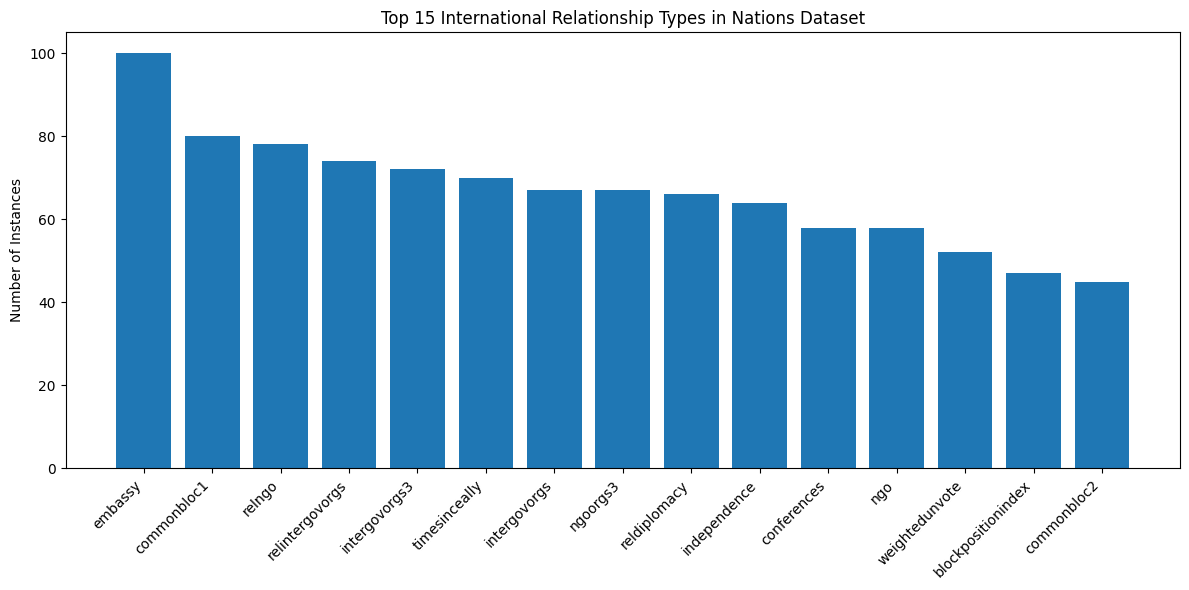


💡 Example relationships:
  usa          --[treaties       ]--> israel
  china        --[warning        ]--> usa
  brazil       --[commonbloc1    ]--> burma
  india        --[relngo         ]--> brazil
  egypt        --[reltreaties    ]--> brazil
  egypt        --[timesinceally  ]--> poland
  china        --[relngo         ]--> israel
  china        --[warning        ]--> india
  ussr         --[timesinceally  ]--> egypt
  poland       --[reldiplomacy   ]--> indonesia


In [6]:
# Visualize relationship distribution
plt.figure(figsize=(12, 6))
top_relations = dict(relation_counts.most_common(15))
plt.bar(range(len(top_relations)), list(top_relations.values()))
plt.xticks(range(len(top_relations)), list(top_relations.keys()), rotation=45, ha='right')
plt.title('Top 15 International Relationship Types in Nations Dataset')
plt.ylabel('Number of Instances')
plt.tight_layout()
plt.show()

# Show some example relationships
print("\n💡 Example relationships:")
edges = list(nations_graph.edges(data=True))
import random
random.seed(42)
sample_edges = random.sample(edges, min(10, len(edges)))

for source, target, data in sample_edges:
    relation = data['relation']
    print(f"  {source:12} --[{relation:15}]--> {target}")

## Step 2: Build Graph Database with GraphBuilder

In [7]:
# Initialize GraphBuilder
builder = GraphBuilder()

print("🔧 GraphBuilder Info:")
info = builder.get_info()
for key, value in info.items():
    print(f"  {key}: {value}")

print("\n📦 Building Nations graph database...")

# Extract node and edge labels
node_labels = {node: data["type"] for node, data in nations_graph.nodes(data=True)}
edge_labels = {(u, v): data["type"] for u, v, data in nations_graph.edges(data=True)}

print(f"🏷️ Creating labels:")
print(f"  - Node types: {set(node_labels.values())}")
print(f"  - Edge types: {len(set(edge_labels.values()))} unique relationship types")

# Build the database
db_path = work_dir / "nations_db"
stats = builder.build_from_networkx(
    graph=nations_graph,
    db_path=db_path,
    graph_name="nations",
    node_labels=node_labels,
    edge_labels=edge_labels
)

print("\n✅ Nations graph database created!")
print(f"📊 Database Statistics:")
for key, value in stats.items():
    if isinstance(value, list) and len(value) > 5:
        print(f"  {key}: {len(value)} items (showing first 5: {value[:5]}...)")
    else:
        print(f"  {key}: {value}")

🔧 GraphBuilder Info:
  name: GraphBuilder
  version: 1.0.0
  description: Build Kuzu graphs from NetworkX or raw data
  inputs: {'networkx': ['graph', 'db_path', 'graph_name', 'node_labels', 'edge_labels'], 'raw_data': ['nodes', 'edges', 'db_path', 'graph_name']}
  outputs: ['statistics', 'db_path']

📦 Building Nations graph database...
🏷️ Creating labels:
  - Node types: {'Country'}
  - Edge types: 24 unique relationship types

✅ Nations graph database created!
📊 Database Statistics:
  node_tables: ['nations_Country']
  edge_tables: 24 items (showing first 5: ['nations_timesinceally_Country_to_Country', 'nations_weightedunvote_Country_to_Country', 'nations_treaties_Country_to_Country', 'nations_commonbloc1_Country_to_Country', 'nations_unweightedunvote_Country_to_Country']...)
  total_nodes: 14
  total_edges: 182
  db_path: /content/auto-graph-rag/nations_demo_workspace/nations_db
  graph_name: nations


## Step 3: Explore Schema with GraphExplorer

In [52]:
!cd auto-graph-rag/ && git branch

  main
* pykeen_graph_integration


In [9]:
# Initialize GraphExplorer
if not has_openai:
    print("❌ OpenAI API key required for schema exploration. Skipping this step.")
else:
    explorer = GraphExplorer(llm_provider="openai", llm_model="gpt-4")

    print("🔧 GraphExplorer Info:")
    info = explorer.get_info()
    for key, value in info.items():
        print(f"  {key}: {value}")

    print("\n🕵️ Exploring Nations graph schema...")
    print("This will analyze the international relationships using GPT-4...")

    # Explore the database
    schema_path = work_dir / "nations_schema.json"
    schema = explorer.explore_from_db(
        db_path=db_path,
        max_samples=20,  # Sample more for richer analysis
        save_schema_to=schema_path
    )

    print("\n✅ Schema exploration complete!")

    # Display schema results
    print(f"\n📋 Discovered Schema Summary:")
    print(f"  {schema['summary']}")

    print(f"\n🌍 Node Types: {list(schema['nodes'].keys())}")
    print(f"🔗 Edge Types: {len(list(schema['edges'].keys()))} relationship types discovered")

    # Show details for Country node type
    if 'Country' in schema['nodes']:
        country_info = schema['nodes']['Country']
        print(f"\n🏛️ Country Node Details:")
        print(f"  Description: {country_info['description']}")
        print(f"  Properties: {country_info['properties']}")
        print(f"  Example: {country_info['example_values']}")

    # Show some interesting relationship types
    print(f"\n🔗 Sample International Relationships:")
    for i, (rel_type, rel_info) in enumerate(list(schema['edges'].items())[:8]):
        print(f"  {i+1}. {rel_type}: {rel_info['description']}")

🔧 GraphExplorer Info:
  name: GraphExplorer
  version: 1.0.0
  description: Explore and understand graph schemas using LLM
  inputs: {'from_db': ['db_path', 'max_samples', 'save_schema_to'], 'from_adapter': ['kuzu_adapter', 'max_samples', 'save_schema_to']}
  outputs: ['schema', 'summary', 'node_types', 'edge_types']

🕵️ Exploring Nations graph schema...
This will analyze the international relationships using GPT-4...
DEBUG: Starting multi-step schema exploration...
DEBUG: Got schema overview with 1 node tables, 24 edge tables
DEBUG: Analyzed 1 node types
DEBUG: LLM response for edge batch: {
  "nations_intergovorgs3_Country_to_Country": {
    "description": "This relationship represents the interaction between two countries within the context of international governmental organizations.",
    "source": "nations_Country",
    "target": "nations_Country",
    "cardinality": "Many-to-Many",
    "properties": ["relation"],
    "examples": ["burma --[nations_intergovorgs3_Country_to_Countr

## Step 4: Generate Training Data with DataGenerator

In [14]:
# Initialize DataGenerator
if not has_openai:
    print("❌ OpenAI API key required for training data generation. Skipping this step.")
else:
    generator = DataGenerator(llm_provider="openai", llm_model="gpt-4")

    print("🔧 DataGenerator Info:")
    info = generator.get_info()
    for key, value in info.items():
        print(f"  {key}: {value}")

    print("\n📝 Generating training data for international relations...")
    print("This will create diverse question-Cypher pairs about countries and their relationships...")

    # Generate dataset from the schema
    dataset_path = work_dir / "nations_dataset.jsonl"
    dataset = generator.generate_from_schema(
        schema_path=schema_path,
        num_examples=150,  # Good balance for demo
        output_path=dataset_path,
        complexity_distribution={
            1: 0.25,  # Simple lookups: "List all countries", "What countries exist?"
            2: 0.25,  # Filtered queries: "Countries with embassies", "Military alliances"
            3: 0.25,  # Relationships: "Which countries have diplomatic relations?"
            4: 0.25,  # Aggregations: "Count of relationships by type"
        },
        db_path=db_path  # For query validation
    )

    print("\n✅ Training data generated!")

    # Analyze the dataset
    print(f"\n📊 Dataset Statistics:")
    print(f"  Total examples: {len(dataset)}")

    # Complexity and intent analysis
    complexity_counts = Counter(item.get('complexity', 0) for item in dataset)
    intent_counts = Counter(item.get('intent', 'unknown') for item in dataset)

    print(f"  Complexity distribution: {dict(complexity_counts)}")
    print(f"  Intent types: {len(intent_counts)} different intents")

    # Show sample examples focused on international relations
    print(f"\n💡 Sample Training Examples for International Relations:")

    # Find examples with interesting relations
    interesting_examples = []
    keywords = ['embassy', 'military', 'economic', 'alliance', 'tourism', 'trade', 'diplomatic']

    for example in dataset:
        question = example.get('question', '').lower()
        cypher = example.get('cypher', '').lower()
        if any(keyword in question or keyword in cypher for keyword in keywords):
            interesting_examples.append(example)

    # Show a mix of examples
    examples_to_show = interesting_examples[:3] + dataset[:2]  # 3 interesting + 2 random

    for i, example in enumerate(examples_to_show[:5], 1):
        print(f"\n  Example {i}:")
        print(f"    Question: {example.get('question', 'N/A')}")
        cypher = example.get('cypher', 'N/A')
        if len(cypher) > 80:
            cypher = cypher[:77] + "..."
        print(f"    Cypher: {cypher}")
        print(f"    Complexity: {example.get('complexity', 'N/A')}")
        print(f"    Intent: {example.get('intent', 'N/A')}")

🔧 DataGenerator Info:
  name: DataGenerator
  version: 1.0.0
  description: Generate training data from graph schemas
  inputs: {'from_schema': ['schema_path', 'num_examples', 'output_path', 'complexity_distribution', 'db_path'], 'from_dict': ['schema', 'num_examples', 'output_path', 'complexity_distribution', 'kuzu_adapter']}
  outputs: ['dataset', 'statistics']

📝 Generating training data for international relations...
This will create diverse question-Cypher pairs about countries and their relationships...
DEBUG: Using batched question generation approach
DEBUG: Grouped 24 edge types into 3 semantic groups
  - relationships_batch_1_of_3: 10 edge types
  - relationships_batch_2_of_3: 10 edge types
  - relationships_batch_3_of_3: 4 edge types
DEBUG: Generating 62 examples for relationships_batch_1_of_3 group
DEBUG: Generating 15 examples for complexity 1
DEBUG: Generating batch of 3, remaining=15, attempts=0
DEBUG: Valid query: MATCH (n:nations_Country) RETURN n.name...
DEBUG: Valid q

## Step 5: Fine-tune Model with ModelTrainer

⚠️ **Note**: Model training is computationally intensive. For this demo, we'll use a small, efficient configuration.

In [15]:
# Initialize ModelTrainer
trainer = ModelTrainer()

print("🔧 ModelTrainer Info:")
info = trainer.get_info()
for key, value in info.items():
    print(f"  {key}: {value}")

# Configuration for efficient training
model_config = {
    "base_model": "meta-llama/Llama-3.2-1B-Instruct",  # Small, efficient model
    "epochs": 15, # Reduced for demo
    "learning_rate": 5e-4,
    "batch_size": 4,
    "lora_rank": 8,
    "output_dir": str(work_dir / "nations_model")
}

print(f"\n⚙️ Training Configuration:")
for key, value in model_config.items():
    print(f"  {key}: {value}")

print(f"\n🎯 Starting model training for international relations...")
print(f"Training a specialized model to understand diplomatic, economic, and political relationships!")

# Train the model
model = trainer.train_from_file(
    dataset_path=dataset_path,
    model_name=model_config["base_model"],
    output_dir=Path(model_config["output_dir"]),
    epochs=model_config["epochs"],
    learning_rate=model_config["learning_rate"],
    batch_size=model_config["batch_size"],
    lora_rank=model_config["lora_rank"]
)

print("\n✅ Model training completed!")
print(f"🎉 Nations-specialized model ready for international relations queries!")

🔧 ModelTrainer Info:
  name: ModelTrainer
  version: 1.0.0
  description: Fine-tune models on graph query datasets
  inputs: {'from_file': ['dataset_path', 'model_name', 'output_dir', 'epochs', 'learning_rate', 'batch_size', 'lora_rank'], 'from_data': ['dataset', 'model_name', 'output_dir', 'epochs', 'learning_rate', 'batch_size', 'lora_rank']}
  outputs: ['model', 'training_stats', 'model_path']

⚙️ Training Configuration:
  base_model: meta-llama/Llama-3.2-1B-Instruct
  epochs: 15
  learning_rate: 0.0005
  batch_size: 4
  lora_rank: 8
  output_dir: /content/auto-graph-rag/nations_demo_workspace/nations_model

🎯 Starting model training for international relations...
Training a specialized model to understand diplomatic, economic, and political relationships!


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

trainable params: 5,636,096 || all params: 1,241,450,496 || trainable%: 0.4540


Map:   0%|          | 0/115 [00:00<?, ? examples/s]

Map:   0%|          | 0/13 [00:00<?, ? examples/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss
5,3.663900,3.703819
10,3.330500,3.257760
15,2.674300,2.483574
20,1.846800,1.730547
25,1.138100,1.154855
30,0.907300,0.941894
35,0.791900,0.821950
40,0.632300,0.755170
45,0.585800,0.704503
50,0.542700,0.681321


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



✅ Model training completed!
🎉 Nations-specialized model ready for international relations queries!


## Step 6: Query the International Relations Graph with QueryExecutor

In [30]:
# Initialize QueryExecutor
executor = QueryExecutor()

print("🔧 QueryExecutor Info:")
info = executor.get_info()
for key, value in info.items():
    print(f"  {key}: {value}")

# Use the trained model and database
model_path = work_dir / "nations_model"
print(f"\n🎯 Using Assets:")
print(f"  Model: {model_path} (Nations-specialized model)")
print(f"  Database: {db_path} (Nations knowledge graph)")

# International relations test questions
test_questions = [
    "What countries are in the dataset?",
    "Which countries have embassy relationships?",
    "What treaties exist between countries?",
    "What countries gained independance from china?",
    "Which country is in the most ngo relatinoships with other countries?",
    "Which countries does the USA have violent actions with?"
]

print(f"\n❓ Test Questions for International Relations:")
for i, question in enumerate(test_questions, 1):
    print(f"  {i}. {question}")

print(f"\n🤖 Query Execution with Nations-Specialized Model:")
print(f"Let's see how our model handles international relations queries!")

for i, question in enumerate(test_questions, 1):
    print(f"\n{'='*60}")
    print(f"Query {i}: {question}")
    print(f"{'='*60}")

    result = executor.query_with_model(
        question=question,
        model_path=model_path,
        db_path=db_path,
        return_cypher=True,
        format_results=True
    )

    if result['success']:
        print(f"✅ Generated Cypher: {result['cypher']}")
        print(f"📊 Results: {result['count']} rows")

        if 'results' in result and result['results']:
            print(f"\n🔍 Sample Results:")
            # Show more results for international relations
            max_results = min(8, len(result['results']))
            for j, row in enumerate(result['results'][:max_results]):
                print(f"    {j+1:2d}. {row}")
            if len(result['results']) > max_results:
                print(f"    ... and {len(result['results']) - max_results} more")
    else:
        print(f"❌ Error: {result['error']}")

    print()  # Add space between queries

🔧 QueryExecutor Info:
  name: QueryExecutor
  version: 1.0.0
  description: Execute queries with fine-tuned models
  inputs: {'with_paths': ['question', 'model_path', 'db_path', 'return_cypher', 'format_results'], 'with_instances': ['question', 'model', 'kuzu_adapter', 'return_cypher', 'format_results']}
  outputs: ['success', 'cypher', 'results', 'count', 'error']

🎯 Using Assets:
  Model: /content/auto-graph-rag/nations_demo_workspace/nations_model (Nations-specialized model)
  Database: /content/auto-graph-rag/nations_demo_workspace/nations_db (Nations knowledge graph)

❓ Test Questions for International Relations:
  1. What countries are in the dataset?
  2. Which countries have embassy relationships?
  3. What treaties exist between countries?
  4. What countries gained independance from china?
  5. Which country is in the most ngo relatinoships with other countries?
  6. Which countries does the USA have violent actions with?

🤖 Query Execution with Nations-Specialized Model:
Let

 What countries 
   are in the   
    dataset?    
┏━━━━━━━━━━━━━━┓
┃ country_name ┃
┡━━━━━━━━━━━━━━┩
│ brazil       │
│ burma        │
│ china        │
│ cuba         │
│ egypt        │
│ india        │
│ indonesia    │
│ israel       │
│ jordan       │
│ netherlands  │
│ poland       │
│ uk           │
│ usa          │
│ ussr         │
└──────────────┘

✅ Generated Cypher: MATCH (n:nations_Country) RETURN n.name AS country_name
📊 Results: 14 rows

🔍 Sample Results:
     1. {'country_name': 'brazil'}
     2. {'country_name': 'burma'}
     3. {'country_name': 'china'}
     4. {'country_name': 'cuba'}
     5. {'country_name': 'egypt'}
     6. {'country_name': 'india'}
     7. {'country_name': 'indonesia'}
     8. {'country_name': 'israel'}
    ... and 6 more


Query 2: Which countries have embassy relationships?


   Which countries have embassy    
          relationships?           
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ country_name ┃ embassy_relation ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ burma        │ embassy          │
│ cuba         │ embassy          │
│ jordan       │ embassy          │
└──────────────┴──────────────────┘

✅ Generated Cypher: MATCH (c:nations_Country)-[r:nations_embassy_Country_to_Country]->(n:nations_Country) RETURN n.name AS country_name, r.relation AS embassy_relation ORDER BY country_name;
📊 Results: 3 rows

🔍 Sample Results:
     1. {'country_name': 'burma', 'embassy_relation': 'embassy'}
     2. {'country_name': 'cuba', 'embassy_relation': 'embassy'}
     3. {'country_name': 'jordan', 'embassy_relation': 'embassy'}


Query 3: What treaties exist between countries?


  What treaties exist between countries?   
┏━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ c1.name ┃ c2.name     ┃ treaty_relation ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ brazil  │ usa         │ treaties        │
│ china   │ burma       │ treaties        │
│ china   │ cuba        │ treaties        │
│ china   │ egypt       │ treaties        │
│ china   │ indonesia   │ treaties        │
│ china   │ poland      │ treaties        │
│ israel  │ usa         │ treaties        │
│ jordan  │ uk          │ treaties        │
│ poland  │ ussr        │ treaties        │
│ usa     │ brazil      │ treaties        │
│ usa     │ cuba        │ treaties        │
│ usa     │ israel      │ treaties        │
│ usa     │ netherlands │ treaties        │
│ usa     │ ussr        │ treaties        │
│ ussr    │ poland      │ treaties        │
└─────────┴─────────────┴─────────────────┘

✅ Generated Cypher: MATCH (c1:nations_Country)-[r:nations_treaties_Country_to_Country]->(c2:nations_Country) RETURN c1.name, c2.name, r.relation AS treaty_relation ORDER BY c1.name, c2.name;
📊 Results: 15 rows

🔍 Sample Results:
     1. {'c1.name': 'brazil', 'c2.name': 'usa', 'treaty_relation': 'treaties'}
     2. {'c1.name': 'china', 'c2.name': 'burma', 'treaty_relation': 'treaties'}
     3. {'c1.name': 'china', 'c2.name': 'cuba', 'treaty_relation': 'treaties'}
     4. {'c1.name': 'china', 'c2.name': 'egypt', 'treaty_relation': 'treaties'}
     5. {'c1.name': 'china', 'c2.name': 'indonesia', 'treaty_relation': 'treaties'}
     6. {'c1.name': 'china', 'c2.name': 'poland', 'treaty_relation': 'treaties'}
     7. {'c1.name': 'israel', 'c2.name': 'usa', 'treaty_relation': 'treaties'}
     8. {'c1.name': 'jordan', 'c2.name': 'uk', 'treaty_relation': 'treaties'}
    ... and 7 more


Query 4: What countries gained independance from china?


✅ Generated Cypher: MATCH (c:nations_Country {name: 'china'})<-[r:nations_independence_Country_to_Country]-(n:nations_Country) RETURN n.name as Country, r.relation as Independence_Relation ORDER BY Independence_Relation DESC;
📊 Results: 0 rows


Query 5: Which country is in the most ngo relatinoships with other countries?


 Which country is in the most  
 ngo relatinoships with other  
          countries?           
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ c.name    ┃ relations_count ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ indonesia │ 5               │
└───────────┴─────────────────┘

✅ Generated Cypher: MATCH (c:nations_Country)-[r:nations_relngo_Country_to_Country]->(other:nations_Country) RETURN c.name, COUNT(r) AS relations_count ORDER BY relations_count DESC LIMIT 1;
📊 Results: 1 rows

🔍 Sample Results:
     1. {'c.name': 'indonesia', 'relations_count': 5}


Query 6: Which countries does the USA have violent actions with?


Which countries does the USA
 have violent actions with? 
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Country ┃ ViolentActions ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ china   │ violentactions │
└─────────┴────────────────┘

✅ Generated Cypher: MATCH (c1:nations_Country {name: 'usa'})-[r:nations_violentactions_Country_to_Country]->(c2:nations_Country) RETURN c2.name AS Country, r.relation AS ViolentActions
📊 Results: 1 rows

🔍 Sample Results:
     1. {'Country': 'china', 'ViolentActions': 'violentactions'}

